In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from pandas import to_datetime
from prophet import Prophet

sns.set()

Загрузка данные сета.

In [38]:
data = pd.read_csv('T10Y2Y.csv', sep=",")

In [39]:
data.rename(columns={"DATE":"ds","T10Y2Y":"y"},inplace=True)

Оцениваем что в дата-сете есть, и с чем прийдется иметь дело.

In [40]:
data

,ds,y
0,2018-02-20,0.63
1,2018-02-21,0.68
2,2018-02-22,0.67
3,2018-02-23,0.63
4,2018-02-26,0.64
...,...,...
1299,2023-02-13,-0.8
1300,2023-02-14,-0.83
1301,2023-02-15,-0.81
1302,2023-02-16,-0.76


Cмотрим насколько однородны данные и сколько пропущенных элементов в тех или иных столбцах.

In [41]:
data.count()

ds    1304
y     1304
dtype: int64

В процентном соотношении.

In [42]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print(f'{col} - {round(pct_missing * 100, 5)}     min: {data[col].min()}     max:{data[col].max()}')

ds - 0.0     min: 2018-02-20     max:2023-02-17
y - 0.0     min: -0.01     max:1.59


In [43]:
data.describe()

,ds,y
count,1304,1304
unique,1304,225
top,2020-12-29,.
freq,1,54


Видим появившуюся точку заменяем

In [44]:
indexes = data["y"].loc[data["y"] == "."].index
for index in indexes:
    data.iloc[index]["y"] = round((float(data.iloc[index-1]["y"])+float(data.iloc[index+1]["y"]))/2,2)

In [45]:
data[data["y"] == "."].count()

ds    0
y     0
dtype: int64

C:\Users\Monya\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


{'whiskers': [<matplotlib.lines.Line2D at 0x1ae638ee780>,
 'caps': [<matplotlib.lines.Line2D at 0x1ae638c0668>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ae638ee7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1ae638c0ba8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ae638c0e80>],
 'means': []}

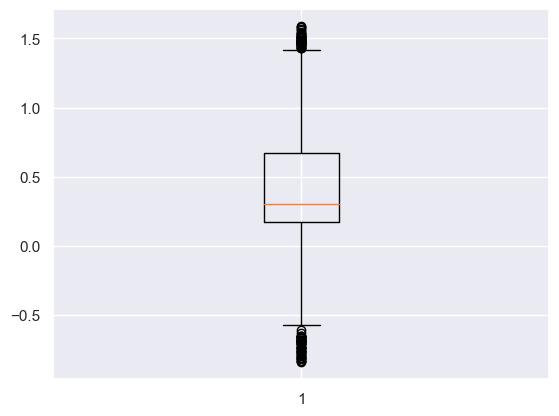

In [46]:
plt.boxplot(data["y"].astype(np.float))

In [47]:
train_data, test_data = data[0:int(len(data) * 0.85)], data[int(len(data) * 0.85):]
print(train_data.shape,test_data.shape)

(1108, 2) (196, 2)


In [48]:
model = Prophet()
model.fit(train_data)

20:46:46 - cmdstanpy - INFO - Chain [1] start processing
20:46:46 - cmdstanpy - INFO - Chain [1] done processing


Создаём предикт.

C:\Users\Monya\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


MAE: 0.099


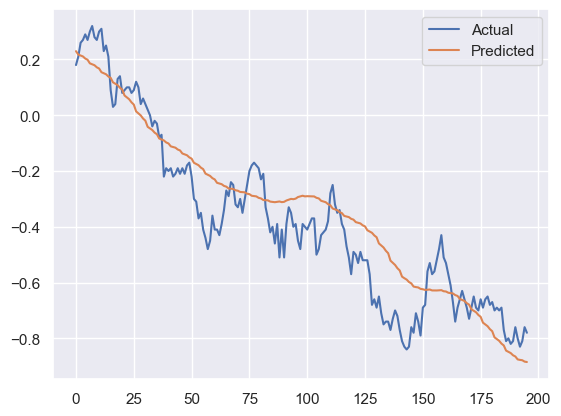

In [49]:
# define the period for which we want a prediction
future = list()
for i in test_data["ds"]:
 future.append([i])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# calculate MAE between expected and predicted values for december
y_true = test_data["y"].astype(np.float).tolist()
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

Предикт на 196 дней себя хорошо оправдал. Посмотрим какие графики покажет сама модель.

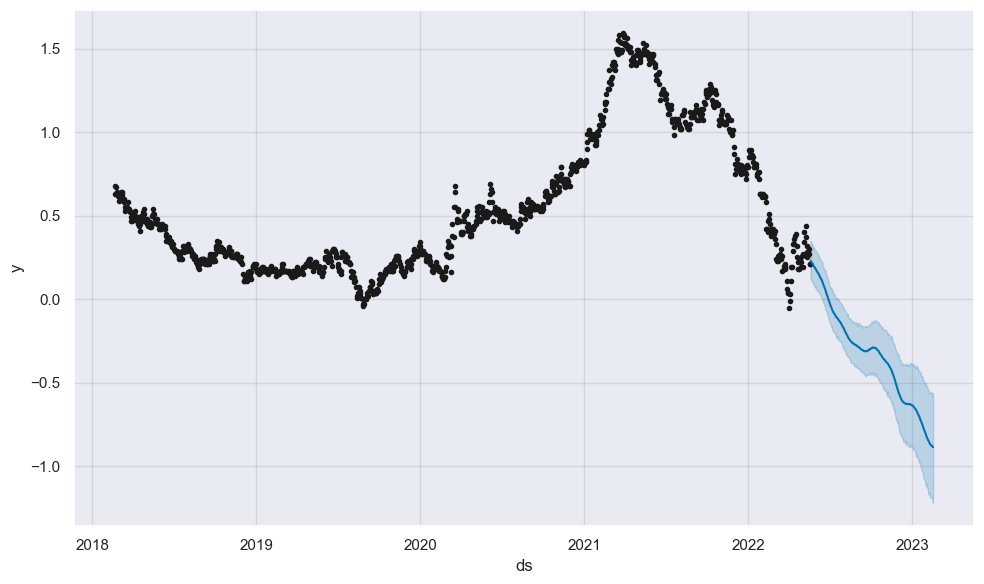

In [50]:
fig_1 = model.plot(forecast)

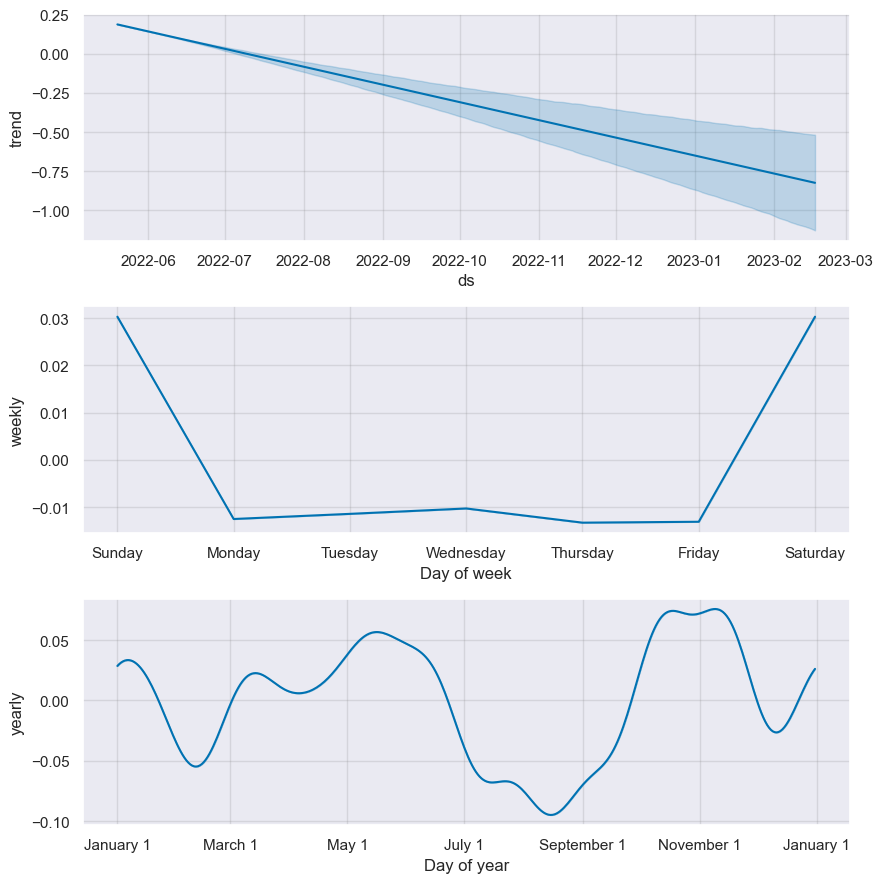

In [51]:
fig_2 = model.plot_components(forecast)